# 0.0. Imports

## 0.1. Julia & Python Imports 

In [1]:
using CSV;
using PyCall;
using PyPlot;
using Printf;

np  = pyimport("numpy");
sns = pyimport("seaborn");
ss  = pyimport("scipy.stats");
wrg = pyimport("warnings");
pd  = pyimport("pandas");

In [2]:
ps = pyimport("pyspark.pandas");
pd = pyimport("databricks.koalas");
tree = pyimport("sklearn.tree");
layers = pyimport("keras.layers");
models = pyimport("keras.models");
prepro = pyimport("sklearn.preprocessing");
utils  = pyimport("sklearn.utils");
metrics = pyimport("sklearn.metrics");
model_selection = pyimport("sklearn.model_selection");

## 0.2. Aux Functions

### 0.2.1. Functions

In [250]:
wrg.filterwarnings("ignore")

### 0.2.1. Plots

In [292]:
function plot_linear(a, b, d, r1, r2)
    fig, ax = plt.subplots( figsize=(6, 5) );

    x = np.arange( r1, r2, 1 )
    y = a * x .+ b + np.random.normal( 0, d, length(x) );
    r = (length(x)sum(x .* y) - (sum(x)sum(y))) / (sqrt((length(x)sum(x.^2) - (sum(x))^2) * (length(y)sum(y.^2) - (sum(y))^2)))
    
    ax = sns.regplot(x, y, color="r")
    if r >= 0
        ax.set_title(("Correlação Positiva: " * string(round(r, digits=4))))
    else
        ax.set_title(("Correlação Negativa: " * string(round(r, digits=4))))
    end
end;

function spearman_plot( size, power )
    log_a = [log1p(abs(j-10)) for j in 1:size]
    log_b = [log1p(j)^power for j in 1:size]
    cor, _ = ss.spearmanr( log_a, log_b );

    fig, ax = plt.subplots( figsize=(5, 5) )
    ax.plot( log_a, color="b", linestyle="--", label="Log - 6" )
    ax.plot( log_b, color="r", linestyle="--", label="Negative Log" )
    ax.set_title( "Correlação: " * string(round(cor, digits=4)) )
    plt.legend(); 
end;

function plot_density( x, y )
    fig, (ax1, ax2) = plt.subplots( 1, 2, figsize=(16, 7) )
    ax1.hexbin( np.random.randn(x), np.random.randn(y), gridsize=30, cmap="gist_heat" );
    ax2 = sns.kdeplot(np.random.randn(x), np.random.randn(y) );
end;

function plot_bootstrap( x, g_type, c )
    plt.hist( x, color=c, linewidth=2, histtype=g_type, bins=20 );
    plt.vlines( np.mean( x ), ymin=n_size-100, ymax=1., color="k", linestyle="--", label="Mean" );
    plt.legend();
end;

# 1.0. Capítulo 1

## 1.1. Correlação

### 1.1.1. R de Pearson

O coeficiente de correlação de pearson é muitas vezes o primeiro coeficiente estudado ou abordado em livros.<br>
São ditos os dados que são positivamente correlacionados quando os valores de **x** acompanham os valores de **y** e negativamente correlacionados se os valores altos de **x** acompanharem os valores baixos de **y**.<br>**Causalidade** a variável **x** é a causa da variável **y**, logo por exemplo a correlação entre número de vendas e clientes é positiva, mas não quer dizer que quantos mais clientes existem mais vendas eu tenha.<br>Ex: O número de consumo de **margarina** e o número de **divórcios** em Maine.

Fórmula do coeficiente de pearson.

$$r = \frac{n(\sum{xy}) - (\sum{x})(\sum{y}))}{\sqrt{(n\sum{(x^2)}-(\sum{x})^2)~(n\sum{(y^2)}-(\sum{y})^2)}}$$

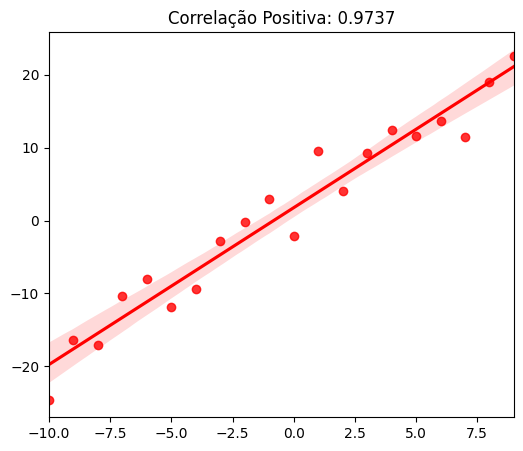

In [191]:
ax1 = plot_linear(2, 2, 3, -10, 10);

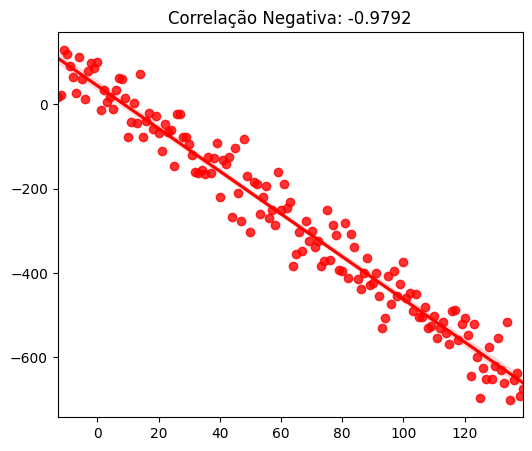

In [8]:
plot_linear(-5, 40, 50, -13, 140);

### 1.1.2. Rho de spearman

Robusto contra outliers e calculado em relação ao ranqueamento ou ordens dos dados, também mede relações lineares e não lineares.

$$r_s = 1 - \frac{6\sum{d^2}}{n^3 - n}$$

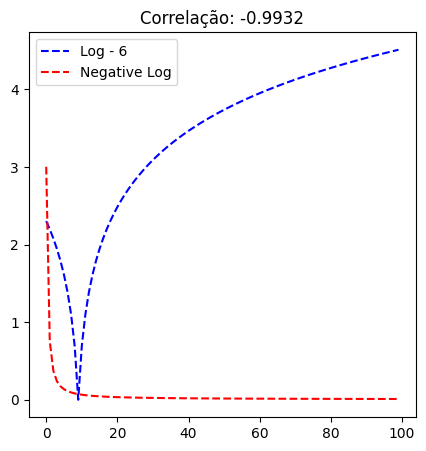

In [96]:
spearman_plot( 100, -3 );

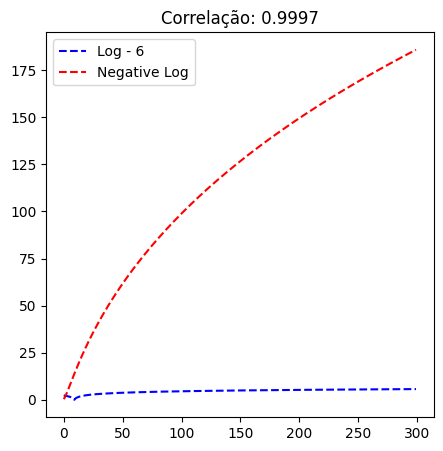

In [97]:
spearman_plot( 300, 3 );

### 1.1.4. V de Cramér

O V de cramér basicamente serve para calcular a correlação entre variaveis categoricas.

Existe a versão corrigida da fórmula de cramér que esta abaixo, k e r são as dimensões da matriz.

$$V = \sqrt{\frac{\varphi^{2}~ou~X^2 / n}{min(k-1, r-1)}}$$

$$\varphi^2 = max(0, \varphi^2 - \frac{(k-1) - (r-1)}{n-1}$$

$$cor~k = k - \frac{(k-1)^2}{n-1}$$

$$cor~r = r - \frac{(r-1)^2}{n-1}$$

In [226]:
df = DataFrame(CSV.File("data/store.csv"))
df = hcat(df[:, 2:3], df.StoreType )
df = rename(df, Dict("x1" => "State"));

# Rename Rows
df.Assortment = [replace(i, "a" => "BASIC") for i in df.Assortment];
df.Assortment = [replace(i, "b" => "EXTRA") for i in df.Assortment];
df.Assortment = [replace(i, "c" => "EXTENDED") for i in df.Assortment];

# Generate FataFrame
results = []
data = DataFrame()

for i in ["StoreType", "Assortment", "State"] 
    a = cramer_v( Array(df.StoreType), Array(df[:, i]) )
    b = cramer_v( Array(df.Assortment), Array(df[:, i]) )
    c = cramer_v( Array(df.State), Array(df[:, i]) )
    
    corr = Dict(i => [a, b, c])
    append!(results, corr)
end

df2 = DataFrame( results ) # Plotar um Mapa de Calor / Heatmap

,StoreType,Assortment,State
,Float64,Float64,Float64
1,1.00135,0.54068,1.00135
2,0.54068,1.0009,0.54068
3,1.00135,0.54068,1.00135


## 1.2. Dois Gráficos de Densidade

Hexagonal Binning relaciona as duas variaveis aleatorias normais em hexágonos, mesma coisa que o Histograma.<br>Kernel Density Estimate, Análogo análogo ao Hexagonal, porem em densidades com curvas. 

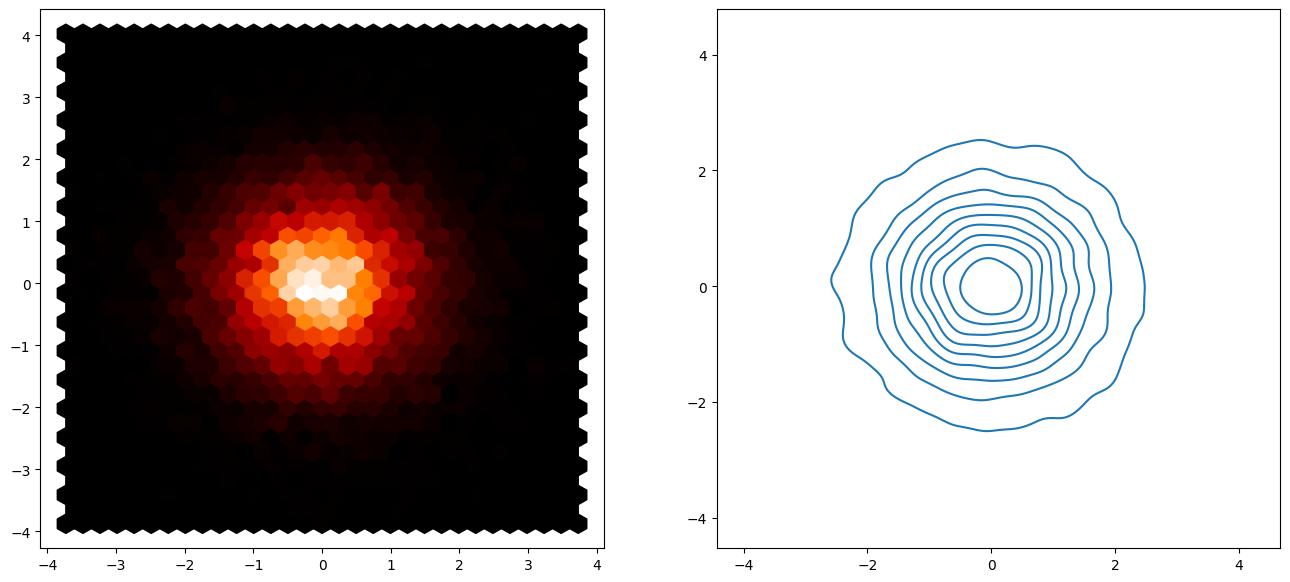

In [160]:
plot_density( 20000, 20000 )
plt.savefig("Density.png")

# x.0. Referências

PETER BRUCE & ANDREW BRUCE **Estatística prática para cientistas de dados: 50 conceitos essenciais**.
<br>Link: https://www.amazon.com.br/Estat%C3%ADstica-Pr%C3%A1tica-Para-Cientistas-Dados/dp/855080603X<br><br>
DAVID MATOS **8 Conceitos Estatísticos Fundamentais Para Data Science**. <br>Link: https://www.cienciaedados.com/8-conceitos-estatisticos-fundamentais-para-data-science/<br><br>IGOR SOARES **Correlação não implica em Causalidade**.<br>Link: https://medium.com/@felipemaiapolo/correla%C3%A7%C3%A3o-n%C3%A3o-implica-em-causalidade-8459179ad1bc.<br><br>annahaensch **Número de Casos de Divórcio em Maine**<br>Link: https://blogs.ams.org/blogonmathblogs/2017/04/10/divorce-and-margarine/